In [ ]:
!pip install ipython-autotime

In [2]:
import h5py
import glob
import seaborn as sns
from ml4cvd.tensor_from_file import _mri_tensor_4d, _mri_hd5_to_structured_grids
from ml4cvd.defines import MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP, MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP, MRI_FRAMES
from ml4cvd.tensor_from_file import _mri_project_grids
from vtk.util import numpy_support as ns
import vtk
import numpy as np
import pandas as pd
from pypoisson import poisson_reconstruction
import os
import imageio

In [ ]:
%load_ext autotime

In [ ]:
MRI_LAX_2CH_SEGMENTED_CHANNEL_MAP = {'left_atrium': 11}

In [ ]:
cli_idxs = [int(idx) for idx in ['2']]

In [ ]:
petersen = pd.read_csv('/home/pdiachil/ml/notebooks/mri/returned_lv_mass.tsv', sep='\t')
petersen_idxs = petersen['sample_id'].values

In [ ]:
petersen_idxs[2]

In [ ]:
# hd5s = glob.glob('/mnt/disks/sax-lax-40k-lvm/2020-01-29/*.hd5')
# results = {f'dice_{d}': [] for d in range(MRI_FRAMES)}
# results['patientid'] = []

# for i, hd5 in enumerate(hd5s):
#     if i % 100 == 0 : print(i)
#     with h5py.File(hd5, 'r') as ff:
#         if 'ukb_cardiac_mri' not in ff:
#             continue
#         try:
#             ds_3ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_3ch_annotated_', view_name='cine_segmented_lax_3ch', concatenate=True, save_path=None, order='F')
#             ds_4ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_4ch_annotated_', view_name='cine_segmented_lax_4ch', concatenate=True, save_path=None, order='F')
#             ds_4ch_3ch = _mri_project_grids(ds_3ch, ds_4ch, 'cine_segmented_lax_3ch_annotated_')
#             ds_3ch_4ch = _mri_project_grids(ds_4ch, ds_3ch, 'cine_segmented_lax_4ch_annotated_')
#         except:
#             continue       
        
#         results['patientid'].append(hd5.split('/')[-1].replace('.hd5', ''))
#         for t in range(MRI_FRAMES):
#             arr_4onto3 = ns.vtk_to_numpy(ds_3ch_4ch[0].GetCellData().GetArray(f'cine_segmented_lax_4ch_annotated__projected_{t}'))
#             arr_3 = ns.vtk_to_numpy(ds_3ch_4ch[0].GetCellData().GetArray(f'cine_segmented_lax_3ch_annotated__{t}'))
#             arr_3onto4 = ns.vtk_to_numpy(ds_4ch_3ch[0].GetCellData().GetArray(f'cine_segmented_lax_3ch_annotated__projected_{t}'))
#             arr_4 = ns.vtk_to_numpy(ds_4ch_3ch[0].GetCellData().GetArray(f'cine_segmented_lax_4ch_annotated__{t}'))
#             cond1 = arr_4onto3 > 0
#             inters1 = np.sum(((arr_4onto3==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond1) & \
#                              ((arr_3==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond1))
#             union1 = np.sum(((arr_4onto3==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond1) | \
#                             ((arr_3==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond1))
#             cond2 = arr_3onto4 > 0
#             inters2 = np.sum(((arr_3onto4==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond2) & \
#                              ((arr_4==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond2))
#             union2 = np.sum(((arr_3onto4==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond2) | \
#                             ((arr_4==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond2))
#             results[f'dice_{t}'].append(np.mean([inters1/union1, inters2/union2]))

In [ ]:
results_df = pd.concat([pd.read_csv(f'/home/pdiachil/intersected_mri_{i}.csv') for i in range(256) \
                        if os.path.isfile(f'/home/pdiachil/intersected_mri_{i}.csv')]).dropna()
results_df

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
results_df['dice_median'] = np.median(results_df.values[:, :-1], axis=1)
f, ax = plt.subplots()
f.set_size_inches(3, 2)
sns.distplot(results_df['dice_median'], kde=False, ax=ax)
ax.set_xlabel('Median Dice over cardiac cycle',)
ax.set_ylabel('Counts')
plt.tight_layout()
f.savefig('dice_distribution.png', dpi=500)

In [ ]:
import matplotlib.animation as anim
import imageio
from IPython.display import HTML, Image
idxs = []
for i, idx in enumerate(results_df.sort_values(by='dice_median').patientid):
    idxs.append(idx)
    with h5py.File(f'/mnt/disks/sax-lax-40k-lvm/2020-01-29/{idx}.hd5') as ff:
        arr_3ch = _mri_tensor_4d(ff, 'cine_segmented_lax_3ch', dest_shape=[256, 256], concatenate=False)
        arr_4ch = _mri_tensor_4d(ff, 'cine_segmented_lax_4ch', dest_shape=[256, 256], concatenate=False)
        arr_annot_3ch = _mri_tensor_4d(ff, 'cine_segmented_lax_3ch_annotated_', concatenate=True)
        arr_annot_4ch = _mri_tensor_4d(ff, 'cine_segmented_lax_4ch_annotated_', concatenate=True)
        arr_annot_3ch_ma = np.ma.masked_array(data=arr_annot_3ch, 
                                              mask=(arr_annot_3ch != MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium'])) 
        arr_annot_4ch_ma = np.ma.masked_array(data=arr_annot_4ch, 
                                              mask=(arr_annot_4ch != MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']))
        f, ax = plt.subplots(1, 2)
        f.set_size_inches(16, 9)
        with imageio.get_writer(f'{idx}.gif', mode='I') as writer:
            for t in range(MRI_FRAMES):
                ax[0].imshow(arr_3ch[:, :, 0, t], cmap='gray')
                ax[0].imshow(arr_annot_3ch_ma[:, :, 0, t], alpha=0.5)
                ax[1].imshow(arr_4ch[:, :, 0, t], cmap='gray')
                ax[1].imshow(arr_annot_4ch_ma[:, :, 0, t], alpha=0.5)                
                f.suptitle(f"Patient: {idx}, Dice = {results_df.sort_values(by='dice_0')[f'dice_{t}'].values[i]}")
                f.savefig(f'tmp_{t}.png', dpi=50)
                image = imageio.imread(f'tmp_{t}.png')
                writer.append_data(image)                
        if i==10: break

In [ ]:
results_df.sort_values(by='dice_median').to_csv('dice_sores_3ch_4ch.tsv', sep='\t', index=False)

In [ ]:
from IPython.display import Image
movies = []
for idx in idxs:
    movies.append(Image(filename=f"{idx}.gif"))
display(*movies)

In [ ]:
idxs = []
for i, idx in enumerate(results_df.sort_values(by='dice_median', ascending=True).patientid):
    if i % (len(results_df)//10000) == 0:
        idxs.append(idx)
    if i > (len(results_df)//10): break

In [ ]:
len(idxs)

In [ ]:
for idx in idxs:
    with h5py.File(f'/mnt/disks/sax-lax-40k-lvm/2020-01-29/{idx}.hd5', 'r') as ff:
        arr_3ch = _mri_tensor_4d(ff, 'cine_segmented_lax_3ch', dest_shape=[256, 256], concatenate=False)
        arr_4ch = _mri_tensor_4d(ff, 'cine_segmented_lax_4ch', dest_shape=[256, 256], concatenate=False)
        arr_annot_3ch = _mri_tensor_4d(ff, 'cine_segmented_lax_3ch_annotated_', concatenate=True)
        arr_annot_4ch = _mri_tensor_4d(ff, 'cine_segmented_lax_4ch_annotated_', concatenate=True)
        arr_annot_3ch_ma = np.ma.masked_array(data=arr_annot_3ch, 
                                              mask=(arr_annot_3ch != MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium'])) 
        arr_annot_4ch_ma = np.ma.masked_array(data=arr_annot_4ch, 
                                              mask=(arr_annot_4ch != MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']))
        ds_3ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_3ch_annotated_', view_name='cine_segmented_lax_3ch', concatenate=True, save_path=None, order='F')
        ds_4ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_4ch_annotated_', view_name='cine_segmented_lax_4ch', concatenate=True, save_path=None, order='F')
        ds_3ch_4ch = _mri_project_grids(ds_3ch, ds_4ch, 'cine_segmented_lax_3ch_annotated_')
        ds_4ch_3ch = _mri_project_grids(ds_4ch, ds_3ch, 'cine_segmented_lax_4ch_annotated_')
        writer = vtk.vtkXMLStructuredGridWriter()
        writer.SetInputData(ds_3ch_4ch[0])
        writer.SetFileName(f'{idx}_3ch_4ch.vts')
        writer.Update()
        writer.SetInputData(ds_4ch_3ch[0])
        writer.SetFileName(f'{idx}_4ch_3ch.vts')
        writer.Update()
        f, ax = plt.subplots(1, 2)
        f.set_size_inches(8, 8)
        with imageio.get_writer(f"overlap_dice_{results_df[results_df['patientid']==idx][f'dice_median'].values[0]}_{idx}.gif", mode='I') as writer:
            for t in range(0, MRI_FRAMES, 10):
                arr_3_4 = ns.vtk_to_numpy(ds_3ch_4ch[0].GetCellData().GetArray(f'cine_segmented_lax_3ch_annotated__projected_{t}'))
                arr_3_4_ma = np.ma.masked_array(data=arr_3_4,
                                                mask=(arr_3_4 != MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']))
                arr_4_3 = ns.vtk_to_numpy(ds_4ch_3ch[0].GetCellData().GetArray(f'cine_segmented_lax_4ch_annotated__projected_{t}'))
                arr_4_3_ma = np.ma.masked_array(data=arr_4_3,
                                                mask=(arr_4_3 != MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']))
                ax[0].imshow(arr_4ch[:, :, 0, t], cmap='gray')
                ax[0].imshow(arr_annot_4ch_ma[:, :, 0, t], alpha=0.5)
                ax[0].imshow(arr_3_4_ma.reshape(arr_annot_4ch_ma.shape[:2], order='F'), alpha=0.5, cmap='Reds') 
                ax[1].imshow(arr_3ch[:, :, 0, t], cmap='gray')
                ax[1].imshow(arr_annot_3ch_ma[:, :, 0, t], alpha=0.5)
                ax[1].imshow(arr_4_3_ma.reshape(arr_annot_3ch_ma.shape[:2], order='F'), alpha=0.5, cmap='Reds') 
                ax[0].set_title(f"Patient: {idx}")
                ax[1].set_title(f"Dice = {results_df[results_df['patientid']==idx][f'dice_{t}'].values}")
                f.savefig(f'overlap_{idx}_{t}.png', dpi=100)
                image = imageio.imread(f"overlap_{idx}_{t}.png")
                writer.append_data(image)       

In [ ]:
from IPython.display import Image
movies = []
for i, idx in enumerate(idxs[:50]):
    movies.append(Image(filename=f"overlap_{idx}.gif", width=1600, height=800))
display(*movies)

In [ ]:
def project_3dpts_plane(pts):
    N = np.cross(pts[10] - pts[0], pts[200] - pts[0])
    U = (pts[10] - pts[0])/np.linalg.norm(pts[10] - pts[0])
    uN = N / np.linalg.norm(N)
    u = pts[0] + U  
    V = np.cross(U, uN)
    v = pts[0] + V
    n = pts[0] + uN
    S = np.ones((4, 4))
    S[:-1, 0] = pts[0]
    S[:-1, 1] = u
    S[:-1, 2] = v
    S[:-1, 3] = n
    Sinv = np.linalg.inv(S)
    D = np.zeros((4, 4))
    D[-1] = 1
    D[0, 1] = 1
    D[1, 2] = 1
    D[2, 3] = 1
    M = np.dot(D, Sinv)
#     f, ax = plt.subplots()
#     ax = f.add_subplot(111, projection='3d')
#     ax.scatter(*pts[0])
#     ax.scatter(*v)
#     ax.scatter(*n)
#     ax.scatter(*u)
    pts_tmp = np.zeros((4, len(pts)))
    pts_tmp[:-1, :] = pts.T
    pts_tmp[-1] = 1
    return np.dot(M, pts_tmp)[:-1].T
    

In [ ]:
# petersen_idxs = []
# hd5s = glob.glob(f'/mnt/disks/sax-and-lax-zip-2019-09-30/unzip-sax-and-lax-44k-2020-06-05/*.hd5')
# for hd5 in hd5s:
#     with h5py.File(hd5, 'r') as ff:
#         try:
#             for k in ff['continuous'].keys():
#                 if 'LA_' in k: 
#                     petersen_idxs.append(hd5)
#         except:
#             pass

In [3]:
petersen = pd.read_csv('returned_lv_mass.tsv', sep='\t')
petersen_idxs = petersen['sample_id'].values
for t in range(MRI_FRAMES):
    petersen[f'LA_poisson_{t}'] = 0.0

In [ ]:
from scipy.spatial import ConvexHull
volumes = []
for i, idx in enumerate(petersen_idxs):
    if (i % 10) == 0: 
        print(f'{i} out of {len(petersen_idxs)}')
    if i == 1:
        break
    try:
        with h5py.File(f'/mnt/disks/sax-and-lax-zip-2019-09-30/unzip-sax-and-lax-44k-2020-06-05/{idx}.hd5', 'r') as ff:
            ds_2ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_2ch_annotated_', view_name='cine_segmented_lax_2ch', concatenate=True, save_path=None, order='F')
            ds_3ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_3ch_annotated_', view_name='cine_segmented_lax_3ch', concatenate=True, save_path=None, order='F')
            ds_4ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_4ch_annotated_', view_name='cine_segmented_lax_4ch', concatenate=True, save_path=None, order='F')
        
            centers_2ch = vtk.vtkCellCenters()
            centers_2ch.SetInputData(ds_2ch[0])
            centers_2ch.Update()
            centers_3ch = vtk.vtkCellCenters()
            centers_3ch.SetInputData(ds_3ch[0])
            centers_3ch.Update()
            centers_4ch = vtk.vtkCellCenters()
            centers_4ch.SetInputData(ds_4ch[0])
            centers_4ch.Update()
            for t in range(MRI_FRAMES):
                arr_annot_2ch = ns.vtk_to_numpy(ds_2ch[0].GetCellData().GetArray(f'cine_segmented_lax_2ch_annotated__{t}'))
                arr_annot_3ch = ns.vtk_to_numpy(ds_3ch[0].GetCellData().GetArray(f'cine_segmented_lax_3ch_annotated__{t}'))
                arr_annot_4ch = ns.vtk_to_numpy(ds_4ch[0].GetCellData().GetArray(f'cine_segmented_lax_4ch_annotated__{t}'))
                idx_2ch = np.where(arr_annot_2ch == MRI_LAX_2CH_SEGMENTED_CHANNEL_MAP['left_atrium'])
                idx_3ch = np.where(arr_annot_3ch == MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium'])
                idx_4ch = np.where(arr_annot_4ch == MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity'])
                pts_2ch = ns.vtk_to_numpy(centers_2ch.GetOutput().GetPoints().GetData())[idx_2ch]
                pts_2ch_2d = project_3dpts_plane(pts_2ch)
                n_2ch = np.cross(pts_2ch[10] - pts_2ch[0], pts_2ch[200] - pts_2ch[0])
                n_2ch /= np.linalg.norm(n_2ch)
                pts_3ch = ns.vtk_to_numpy(centers_3ch.GetOutput().GetPoints().GetData())[idx_3ch]
                pts_3ch_2d = project_3dpts_plane(pts_3ch)
                n_3ch = np.cross(pts_3ch[10] - pts_3ch[0], pts_3ch[200] - pts_3ch[0])
                n_3ch /= np.linalg.norm(n_3ch)
                pts_4ch = ns.vtk_to_numpy(centers_4ch.GetOutput().GetPoints().GetData())[idx_4ch]
                pts_4ch_2d = project_3dpts_plane(pts_4ch)
                n_4ch = np.cross(pts_4ch[10] - pts_4ch[0], pts_4ch[200] - pts_4ch[0])
                n_4ch /= np.linalg.norm(n_4ch)
                hull_2ch = ConvexHull(pts_2ch_2d[:, :-1])
                hull_3ch = ConvexHull(pts_3ch_2d[:, :-1])
                hull_4ch = ConvexHull(pts_4ch_2d[:, :-1])
                pts_hull_2ch = pts_2ch[hull_2ch.vertices]
                pts_hull_3ch = pts_3ch[hull_3ch.vertices]
                pts_hull_4ch = pts_4ch[hull_4ch.vertices]
                pts1_hull_2ch = np.zeros_like(pts_hull_2ch)
                pts1_hull_3ch = np.zeros_like(pts_hull_3ch)
                pts1_hull_4ch = np.zeros_like(pts_hull_4ch)
                pts1_hull_2ch[:-1] = pts_hull_2ch[1:]
                pts1_hull_2ch[-1] = pts_hull_2ch[0]
                pts1_hull_3ch[:-1] = pts_hull_3ch[1:]
                pts1_hull_3ch[-1] = pts_hull_3ch[0]
                pts1_hull_4ch[:-1] = pts_hull_4ch[1:]
                pts1_hull_4ch[-1] = pts_hull_4ch[0]
                n_hull_2ch = np.cross(pts1_hull_2ch-pts_hull_2ch, n_2ch)
                n_hull_2ch /= np.linalg.norm(n_hull_2ch, axis=1).reshape(-1, 1)
                n_hull_3ch = np.cross(pts1_hull_3ch-pts_hull_3ch, n_3ch)
                n_hull_3ch /= np.linalg.norm(n_hull_3ch, axis=1).reshape(-1, 1)
                n_hull_4ch = np.cross(pts1_hull_4ch-pts_hull_4ch, n_4ch)
                n_hull_4ch /= np.linalg.norm(n_hull_4ch, axis=1).reshape(-1, 1)
                n1_hull_2ch = np.zeros_like(n_hull_2ch)
                n1_hull_2ch[1:] = n_hull_2ch[:-1]
                n1_hull_2ch[0] = n_hull_2ch[-1]
                n_hull_2ch = -0.5*(n_hull_2ch + n1_hull_2ch)
                n1_hull_3ch = np.zeros_like(n_hull_3ch)
                n1_hull_3ch[1:] = n_hull_3ch[:-1]
                n1_hull_3ch[0] = n_hull_3ch[-1]
                n_hull_3ch = -0.5*(n_hull_3ch + n1_hull_3ch)
                n1_hull_4ch = np.zeros_like(n_hull_4ch)
                n1_hull_4ch[1:] = n_hull_4ch[:-1]
                n1_hull_4ch[0] = n_hull_4ch[-1]
                n_hull_4ch = -0.5*(n_hull_4ch + n1_hull_4ch)       
                pts = np.vstack([pts_hull_2ch, pts_hull_3ch, pts_hull_4ch])
                normals = np.vstack([n_hull_2ch, n_hull_3ch, n_hull_4ch])
                faces, vertices = poisson_reconstruction(pts, normals, depth=16)
                faces_tmp = np.zeros((len(faces), 4), dtype=np.int64)
                faces_tmp[:, 0] = 3
                faces_tmp[:, 1:] = faces 
                polydata_points = vtk.vtkPoints()
                polydata_points.SetData(ns.numpy_to_vtk(vertices))
                polydata_cells = vtk.vtkCellArray()
                polydata_cells.SetNumberOfCells(len(faces))
                polydata_cells.SetCells(len(faces), ns.numpy_to_vtkIdTypeArray(faces_tmp.ravel()))

                polydata = vtk.vtkPolyData()
                polydata.SetPoints(polydata_points)
                polydata.SetPolys(polydata_cells)
            
                boundary_edges = vtk.vtkFeatureEdges()
                boundary_edges.SetInputData(polydata)
                boundary_edges.BoundaryEdgesOn()
                boundary_edges.FeatureEdgesOff()
                boundary_edges.NonManifoldEdgesOff()
                boundary_edges.ManifoldEdgesOff()    
            
                boundary_strips = vtk.vtkStripper()
                boundary_strips.SetInputConnection(boundary_edges.GetOutputPort())
                boundary_strips.Update()
            
                boundary_poly = vtk.vtkPolyData()
                boundary_poly.SetPoints(boundary_strips.GetOutput().GetPoints())
                boundary_poly.SetPolys(boundary_strips.GetOutput().GetLines())
            
                append = vtk.vtkAppendPolyData()
                append.UserManagedInputsOn()
                append.SetNumberOfInputs(2)
                append.SetInputDataByNumber(0, polydata)
                append.SetInputDataByNumber(1, boundary_poly)
                append.Update()
            
                clean = vtk.vtkCleanPolyData()
                clean.ConvertLinesToPointsOff()
                clean.ConvertPolysToLinesOff()
                clean.ConvertStripsToPolysOff()
                clean.PointMergingOn()
                clean.SetInputConnection(append.GetOutputPort())
                clean.Update()

                triangle_filter = vtk.vtkTriangleFilter()
                triangle_filter.SetInputConnection(clean.GetOutputPort())
                triangle_filter.Update()
            
                mass = vtk.vtkMassProperties()
                mass.SetInputConnection(triangle_filter.GetOutputPort())
                mass.Update()
                petersen.loc[i, f'LA_poisson_{t}'] = mass.GetVolume()
                if t==10:
                    break
                
                writer = vtk.vtkXMLPolyDataWriter()
                writer.SetInputConnection(clean.GetOutputPort())
                writer.SetFileName(f'atrium_{t}.vtp')
                writer.Update()
    except:
        pass

In [17]:
petersen = pd.concat([pd.read_csv(f'/home/pdiachil/atria_poisson_output/petersen_{t}.csv', sep='\t') for t in range(32)])
petersen = petersen.reset_index(drop=True)

In [14]:
petersen

,appid_2964,sample_id,cvi42wsx,json,LA_2Ch_vol_max,LA_2Ch_vol_min,LA_4Ch_vol_max,LA_4Ch_vol_min,LA_Biplan_vol_max,LA_Biplan_vol_min,...,LA_poisson_40,LA_poisson_41,LA_poisson_42,LA_poisson_43,LA_poisson_44,LA_poisson_45,LA_poisson_46,LA_poisson_47,LA_poisson_48,LA_poisson_49
0,4938514,5900391,True,True,115.000,55.000,144.000,72.000,129.000,63.000,...,92677.955854,92994.188181,81137.083798,59163.151361,80171.236795,67451.662363,72635.093551,70365.206749,66782.732243,69799.638611
0,2432774,5143081,True,True,30.000,15.000,53.000,29.000,39.000,20.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,5224160,3317888,True,True,141.000,94.000,133.000,74.000,137.000,84.000,...,92945.978433,91250.022849,81293.370660,80180.933946,80189.255119,66965.787092,75505.684016,70634.301791,63742.308434,59694.906666
0,5757389,2047370,True,True,88.000,25.000,99.000,42.000,92.000,30.000,...,87276.188294,83818.506276,67598.761065,66314.664400,62723.817568,56062.896453,50315.269413,52314.087853,42852.015342,51255.596332
0,1973474,5382795,True,True,141.000,66.000,123.000,53.000,132.000,59.000,...,134350.529609,128574.375347,127786.671051,136722.226434,143702.111565,97965.052286,106140.452245,103258.031150,122039.156839,114576.804839
0,1966729,2809959,True,True,64.000,33.000,95.000,36.000,78.000,34.000,...,58862.210849,57092.024300,47629.953453,48063.754463,42033.985505,37824.047254,43196.263109,43712.065954,43101.235560,44626.935362
0,3017943,3650103,True,True,87.917,50.255,75.178,36.930,80.889,42.927,...,91424.605305,124910.440799,135181.233525,60012.921341,111350.428744,113110.009396,110740.337195,270125.930535,96272.579094,85032.335258
0,4446431,5203326,True,True,109.000,67.000,109.000,61.000,109.000,64.000,...,98357.355544,95249.628726,89143.256494,81597.857388,75300.031614,78075.098977,76489.333219,69178.799341,65194.891605,71638.197241
0,1171933,2394802,True,True,75.000,34.000,87.000,37.000,80.000,35.000,...,102448.127073,95917.515373,94460.596013,83950.012987,83373.977286,83144.981365,83608.474693,76579.776765,75789.599782,80101.332302
0,2886628,4951389,True,True,239.000,237.000,322.000,279.000,275.000,258.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


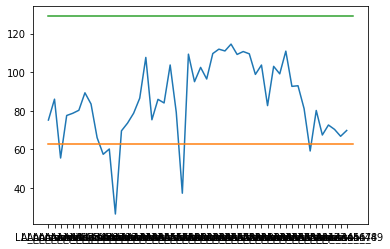

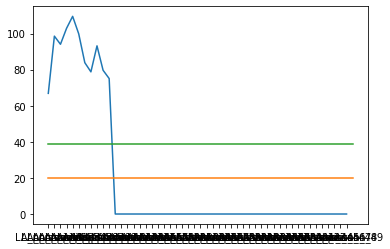

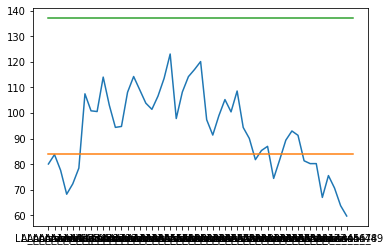

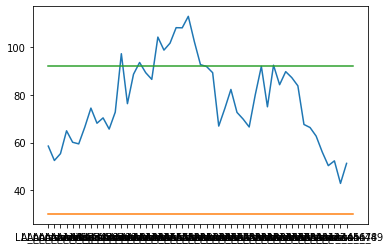

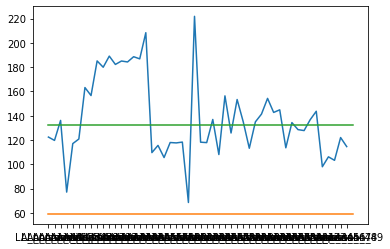

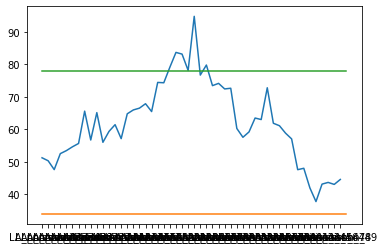

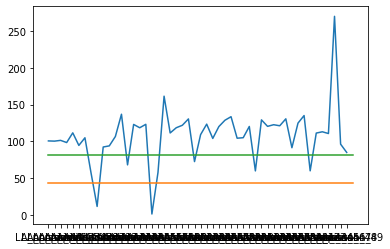

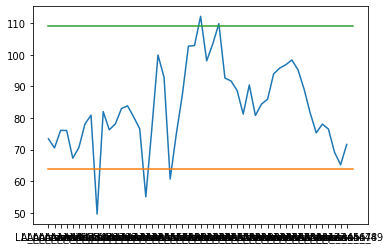

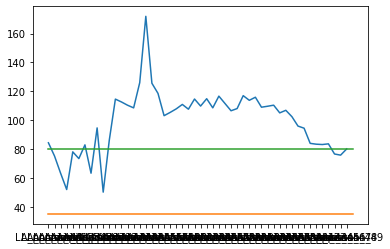

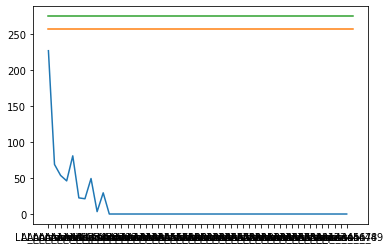

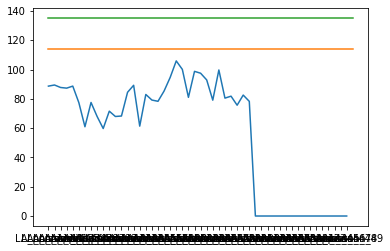

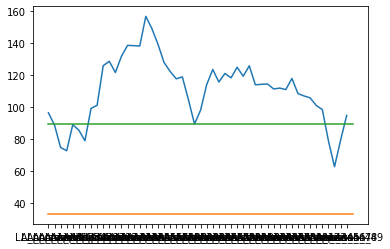

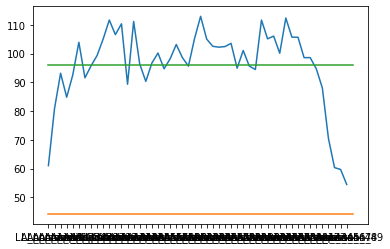

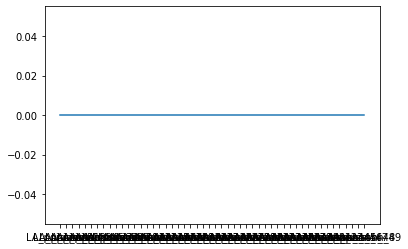

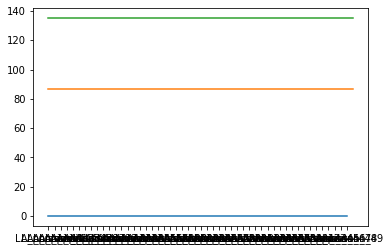

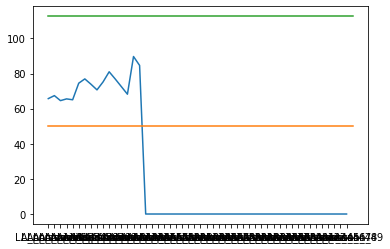

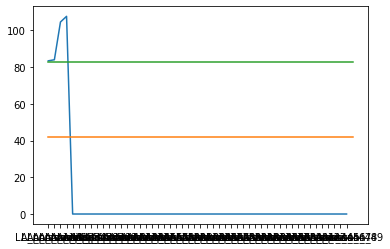

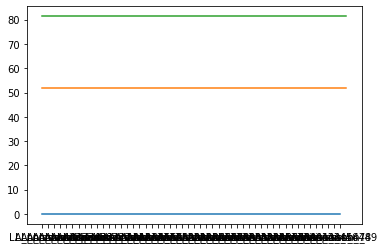

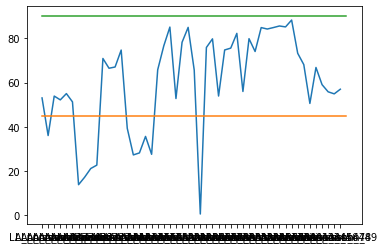

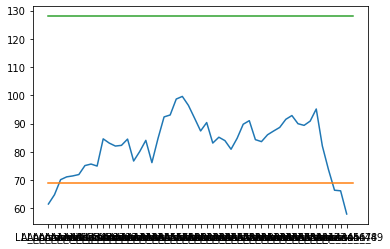

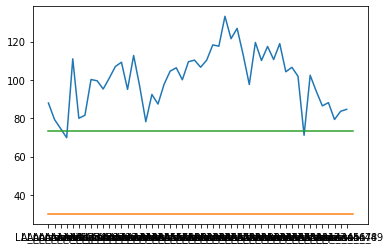

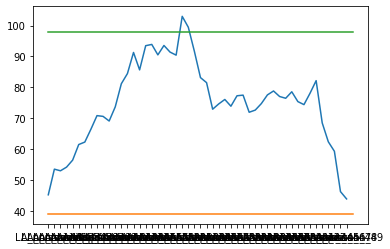

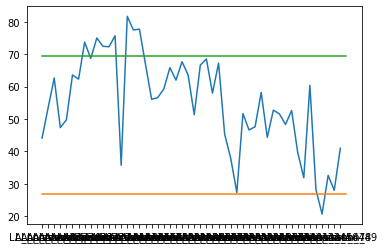

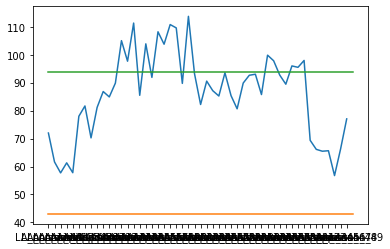

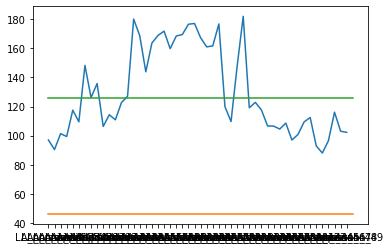

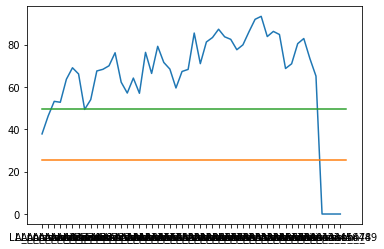

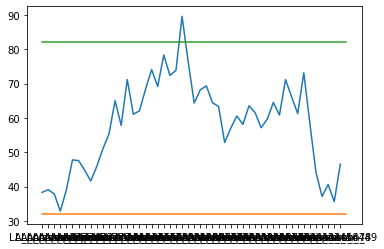

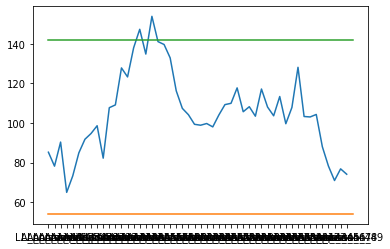

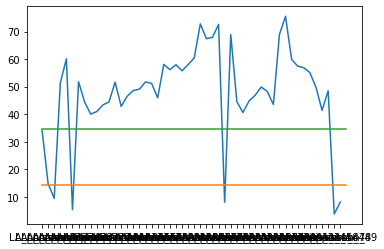

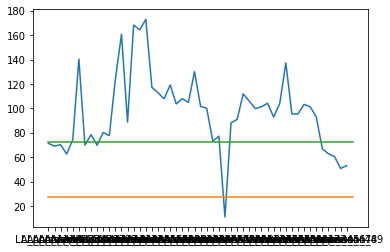

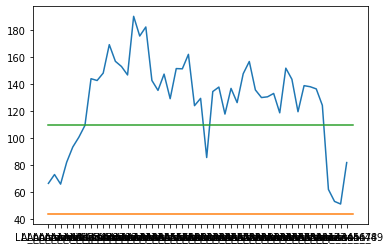

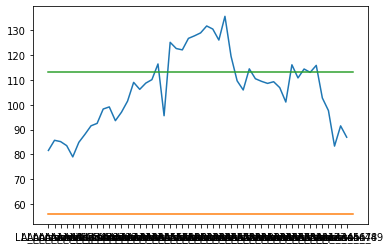

In [19]:
list_la = [f'LA_poisson_{t}' for t in range(MRI_FRAMES)]
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(32):
    f, ax = plt.subplots()
    ax.plot(petersen.loc[i, list_la]/1000.0)
    ax.plot([0.0, 50.0], [petersen.loc[i, 'LA_Biplan_vol_min'], petersen.loc[i, 'LA_Biplan_vol_min']])
    ax.plot([0.0, 50.0], [petersen.loc[i, 'LA_Biplan_vol_max'], petersen.loc[i, 'LA_Biplan_vol_max']])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 2)
ax[0].imshow(arr_annot_2ch.reshape(-1, 256))
ax[1].imshow(arr_annot_2ch.reshape(-1, 256) == 11)

In [ ]:
for t in range(MRI_FRAMES):
    arr = ds_2ch[0].GetCellData().GetArray(f'cine_segmented_lax_2ch_annotated__{t}')
    if ds_2ch[0].GetCellData().GetArray('cine_segmented_lax_2ch_annotated') is not None:
        ds_2ch[0].GetCellData().RemoveArray('cine_segmented_lax_2ch_annotated')
    arr.SetName('cine_segmented_lax_2ch_annotated')
    ds_2ch[0].GetCellData().AddArray(arr)
    writer = vtk.vtkXMLStructuredGridWriter()
    writer.SetInputData(ds_2ch[0])
    writer.SetFileName(f'2ch_{t}.vts')
    writer.Update()
    
    arr = ds_3ch[0].GetCellData().GetArray(f'cine_segmented_lax_3ch_annotated__{t}')
    if ds_3ch[0].GetCellData().GetArray('cine_segmented_lax_3ch_annotated') is not None:
        ds_3ch[0].GetCellData().RemoveArray('cine_segmented_lax_3ch_annotated')
    arr.SetName('cine_segmented_lax_3ch_annotated')
    ds_3ch[0].GetCellData().AddArray(arr)
    writer = vtk.vtkXMLStructuredGridWriter()
    writer.SetInputData(ds_3ch[0])
    writer.SetFileName(f'3ch_{t}.vts')
    writer.Update()
    
    arr = ds_4ch[0].GetCellData().GetArray(f'cine_segmented_lax_4ch_annotated__{t}')
    if ds_4ch[0].GetCellData().GetArray('cine_segmented_lax_4ch_annotated') is not None:
        ds_4ch[0].GetCellData().RemoveArray('cine_segmented_lax_4ch_annotated')
    arr.SetName('cine_segmented_lax_4ch_annotated')
    ds_4ch[0].GetCellData().AddArray(arr)
    writer = vtk.vtkXMLStructuredGridWriter()
    writer.SetInputData(ds_4ch[0])
    writer.SetFileName(f'4ch_{t}.vts')
    writer.Update()
    

In [ ]:
print(ds_3ch[0].GetCellData())

In [ ]:
%matplotlib inline
f, ax = plt.subplots()
ax = f.add_subplot(111, projection='3d')
ax.plot(pts_hull_4ch[:, 0], pts_hull_4ch[:, 1], pts_hull_4ch[:, 2])
#ax.plot(pts_hull_4ch[:, 0], pts_hull_4ch[:, 1], pts_hull_4ch[:, 2])
for pt, n  in zip(pts_hull_4ch, n_hull_4ch):
    ax.plot([pt[0], pt[0]+n[0]], 
            [pt[1], pt[1]+n[1]], 
            [pt[2], pt[2]+n[2]])

In [ ]:
from pypoisson import poisson_reconstruction
from mpl_toolkits.mplot3d import Axes3D

faces, vertices = poisson_reconstruction(pts, normals, depth=16)

faces_tmp = np.zeros((len(faces), 4), dtype=np.int64)
faces_tmp[:, 0] = 3
faces_tmp[:, 1:] = faces 
polydata_points = vtk.vtkPoints()
polydata_points.SetData(ns.numpy_to_vtk(vertices))
polydata_cells = vtk.vtkCellArray()
polydata_cells.SetNumberOfCells(len(faces))
polydata_cells.SetCells(len(faces), ns.numpy_to_vtkIdTypeArray(faces_tmp.ravel()))

polydata = vtk.vtkPolyData()
polydata.SetPoints(polydata_points)
polydata.SetPolys(polydata_cells)

f, ax = plt.subplots()
ax = f.add_subplot(111, projection='3d')
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2])
ax.plot(pts_hull_3ch[:, 0], pts_hull_3ch[:, 1], pts_hull_3ch[:, 2])
ax.plot(pts_hull_4ch[:, 0], pts_hull_4ch[:, 1], pts_hull_4ch[:, 2])

In [ ]:
writer = vtk.vtkXMLPolyDataWriter()
writer.SetInputData(polydata)
writer.SetFileName('atrium.vtp')
writer.Update()

writer = vtk.vtkXMLStructuredGridWriter()
writer.SetInputData(ds_4ch[0])
writer.SetFileName('4ch.vts')
writer.Update()
writer.SetInputData(ds_3ch[0])
writer.SetFileName('3ch.vts')
writer.Update()


In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
f, ax = plt.subplots()
ax = f.add_subplot(111, projection='3d')
ax.scatter(pts_hull[:, 0], pts_hull[:, 1], pts_hull[:, 2])


In [ ]:
n = len(pts_hull)

D = np.zeros((10, n))
D[0, :] = pts_hull[:, 0]**2.0
D[1, :] = pts_hull[:, 1]**2.0
D[2, :] = pts_hull[:, 2]**2.0
D[3, :] = np.sqrt(2)*pts_hull[:, 0]*pts_hull[:, 1]
D[4, :] = np.sqrt(2)*pts_hull[:, 0]*pts_hull[:, 2]
D[5, :] = np.sqrt(2)*pts_hull[:, 1]*pts_hull[:, 2]
D[6, :] = pts_hull[:, 0]
D[7, :] = pts_hull[:, 1]
D[8, :] = pts_hull[:, 2]
D[9, :] = 1;

K = np.matmul(D, D.T)

## The objective is now to solve min <q,Kq>, ||q||=1
_, _, V1 = np.linalg.svd(K)
q = V1[:, 9]
q = q / np.sum(q[0:2]);
if q[0] < 0:
    q = -q

A = np.array([[q[0], q[3]/np.sqrt(2), q[4]/np.sqrt(2)],
              [q[3]/np.sqrt(2), q[2], q[5]/np.sqrt(2)],
              [q[4]/np.sqrt(2), q[5]/np.sqrt(2), q[2]]])

if np.min(np.linalg.eig(A)[0]) <= 0: 
    print('Beware, the LLS solution is not an ellipse')

b = [q[6], q[7], q[8]]
c = q[9]

In [ ]:
X, Y, Z = np.meshgrid(np.linspace(np.min(pts_hull[:, 0])-10, np.max(pts_hull[:, 0])+10, 200),
                      np.linspace(np.min(pts_hull[:, 1])-10, np.max(pts_hull[:, 1])+10, 200),
                      np.linspace(np.min(pts_hull[:, 2])-10, np.max(pts_hull[:, 2])+10, 200))

V = q[0]*X**2 + q[1]*Y**2 + q[2]*Z**2 + np.sqrt(2)*q[3]*X*Y + np.sqrt(2)*q[4]*X*Z + np.sqrt(2)*q[5]*Y*Z+\
    q[6]*X + q[7]*Y + q[8]*Z + q[9]



In [ ]:
from skimage import measure
verts, faces, _, _ = measure.marching_cubes_lewiner(V, 0, spacing=(2.0, 2.0, 2.0))

In [ ]:
faces.shape

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)
ax.scatter(pts_hull[:, 0], pts_hull[:, 1], pts_hull[:, 2])

In [ ]:

#arr_3ch = _mri_tensor_4d(ff, 'cine_segmented_lax_3ch')

#arr_4ch = _mri_tensor_4d(ff, 'cine_segmented_lax_4ch')

In [ ]:
ds_3ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_3ch_annotated_', view_name='cine_segmented_lax_3ch', concatenate=True, save_path=None, order='F')
ds_4ch = _mri_hd5_to_structured_grids(ff, 'cine_segmented_lax_4ch_annotated_', view_name='cine_segmented_lax_4ch', concatenate=True, save_path=None, order='F')

In [ ]:
from ml4cvd.tensor_from_file import _mri_project_grids
ds_4ch_3ch = _mri_project_grids(ds_3ch, ds_4ch, 'cine_segmented_lax_3ch_annotated_')
ds_3ch_4ch = _mri_project_grids(ds_4ch, ds_3ch, 'cine_segmented_lax_4ch_annotated_')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 2)
ax[0].imshow(arr_annot_3ch[:, :, 0, 0]==2)
ax[1].imshow(arr_annot_4ch[:, :, 0, 0]==10)

In [ ]:
import vtk
from vtk.util import numpy_support as ns
writer = vtk.vtkXMLStructuredGridWriter()
writer.SetInputData(ds_4ch_3ch[0])
writer.SetFileName('3ch_to_4ch.vts')
writer.Update()
writer.SetInputData(ds_3ch_4ch[0])
writer.SetFileName('4ch_to_3ch.vts')
writer.Update()

In [ ]:
writer.SetInputData(ds_3ch[0])
writer.SetFileName('3ch.vts')
writer.Update()

In [ ]:
import numpy as np
for t in range(MRI_FRAMES):
    arr_4onto3 = ns.vtk_to_numpy(ds_3ch_4ch[0].GetCellData().GetArray(f'cine_segmented_lax_4ch_annotated__projected_{t}'))
    arr_3 = ns.vtk_to_numpy(ds_3ch_4ch[0].GetCellData().GetArray(f'cine_segmented_lax_3ch_annotated__{t}'))
    arr_3onto4 = ns.vtk_to_numpy(ds_4ch_3ch[0].GetCellData().GetArray(f'cine_segmented_lax_3ch_annotated__projected_{t}'))
    arr_4 = ns.vtk_to_numpy(ds_4ch_3ch[0].GetCellData().GetArray(f'cine_segmented_lax_4ch_annotated__{t}'))
    cond1 = arr_4onto3 > 0
    inters1 = np.sum(((arr_4onto3==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond1) & \
                     ((arr_3==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond1))
    union1 = np.sum(((arr_4onto3==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond1) | \
                    ((arr_3==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond1))
    cond2 = arr_3onto4 > 0
    inters2 = np.sum(((arr_3onto4==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond2) & \
                     ((arr_4==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond2))
    union2 = np.sum(((arr_3onto4==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond2) | \
                    ((arr_4==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond2))
    print(inters1/union1, inters2/union2)

In [ ]:
import numpy as np
cond1 = arr_4onto3 > 0
inters1 = np.sum(((arr_4onto3==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond1) & \
                 ((arr_3==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond1))
union1 = np.sum(((arr_4onto3==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond1) | \
                ((arr_3==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond1))

In [ ]:
cond2 = arr_3onto4 > 0
inters2 = np.sum(((arr_3onto4==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond2) & \
                 ((arr_4==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond2))
union2 = np.sum(((arr_3onto4==MRI_LAX_3CH_SEGMENTED_CHANNEL_MAP['left_atrium']) & cond2) | \
                ((arr_4==MRI_LAX_4CH_SEGMENTED_CHANNEL_MAP['LA_cavity']) & cond2))

In [ ]:
print(inters1/union1, inters2/union2)

In [ ]:
arr_3onto3 = ns.vtk_to_numpy(ds_3ch_4ch[0].GetCellData().GetArray('cine_segmented_lax_4ch_annotated__projected_0'))
arr_3 = ns.vtk_to_numpy(ds_3ch_4ch[0].GetCellData().GetArray('cine_segmented_lax_3ch_annotated__0'))
arr_3onto4 = ns.vtk_to_numpy(ds_4ch_3ch[0].GetCellData().GetArray('cine_segmented_lax_3ch_annotated__projected_0'))
arr_4 = ns.vtk_to_numpy(ds_4ch_3ch[0].GetCellData().GetArray('cine_segmented_lax_4ch_annotated__0'))